In [18]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
PROJECT_ROOT = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "cleaned_data.csv")

df = pd.read_csv(DATA_PATH)
df.head()

,timestamp,age_group,gender,status,sleep_duration,sleep_quality,night_awakenings,nap_frequency,nap_duration,nap_time,...,screen_time_late,screen_sleep_impact,life_satisfaction_current,life_satisfaction_month,satisfaction_work,satisfaction_social,satisfaction_health,satisfaction_emotional,night_awakenings_raw,night_awakenings_3plus
0,2025-12-20 20:04:51,22–25,Female,Working and studying,7–8 hours,7.0,0.0,Never,I do not nap,I do not nap,...,>2 hours,Minor impact,7.0,7.0,8.0,7.0,6.0,4.0,0,0
1,2025-12-20 16:57:12,18–21,Male,Student,7–8 hours,7.0,2.0,Never,I do not nap,I do not nap,...,1–2 hours,Moderate negative impact,8.0,6.0,8.0,7.0,8.0,5.0,2,0
2,2025-12-20 16:26:50,18–21,Male,Student,6–7 hours,6.0,1.0,Never,20–40 min,After 16:00,...,30–60 min,Moderate negative impact,7.0,6.0,5.0,7.0,8.0,7.0,1,0
3,2025-12-20 16:23:31,18–21,Female,Student,6–7 hours,7.0,0.0,1–2 times per week,20–40 min,After 16:00,...,1–2 hours,Moderate negative impact,7.0,9.0,6.0,6.0,7.0,7.0,0,0
4,2025-12-20 16:19:20,18–21,Male,Student,6–7 hours,9.0,0.0,Never,I do not nap,I do not nap,...,30–60 min,Minor impact,7.0,7.0,6.0,7.0,7.0,7.0,0,0


### Создание Индексов

In [20]:
cluster_features = [
    "sleep_quality",
    "diet_quality",
    "stress_index",
    "wellbeing_index"
]

# Композитный индекс стресса
df["stress_index"] = df[
    ["stress_current", "stress_week", "stress_month"]
].mean(axis=1)

# Композитный индекс благополучия
df["wellbeing_index"] = df[
    [
        "life_satisfaction_current",
        "satisfaction_work",
        "satisfaction_social",
        "satisfaction_health",
        "satisfaction_emotional"
    ]
].mean(axis=1)


### Подготовка данных для кластеризации

In [21]:
X_cluster = df[cluster_features].dropna()

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)


### Выбор оптимального числа кластеров (Elbow Method)

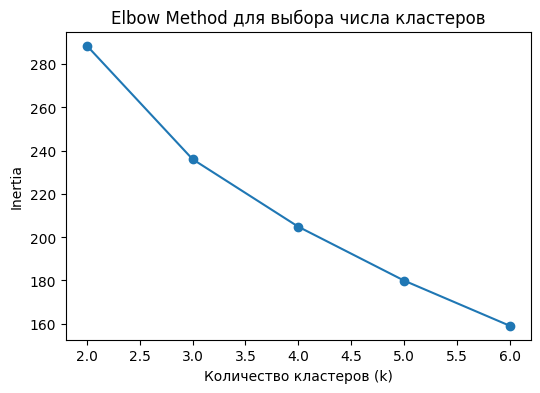

In [22]:
inertia = []
k_range = range(2, 7)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_range, inertia, marker="o")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method для выбора числа кластеров")
plt.show()

### Финальная кластеризация (KMeans)

In [23]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_cluster_scaled)

df["cluster"].value_counts()


cluster
0    49
1    31
2    27
Name: count, dtype: int64

### Профили кластеров


In [24]:
cluster_features = [
    "sleep_quality",
    "diet_quality",
    "stress_index",
    "wellbeing_index"
]

cluster_summary = (
    df.groupby("cluster")[cluster_features]
      .mean()
      .round(2)
)

cluster_summary


,sleep_quality,diet_quality,stress_index,wellbeing_index
cluster,,,,
0,6.61,6.69,7.10,6.18
1,6.39,5.35,3.65,7.23
2,3.56,3.15,7.65,3.54


- Кластер A: высокий стресс, низкое благополучие, более низкое качество сна.
- Кластер B: сбалансированный профиль (умеренный стресс, высокое благополучие).
- Кластер C: хорошие привычки, но повышенная нагрузка (стресс выше среднего при неплохом сне/питании).

### Визуализация кластеров с помощью PCA


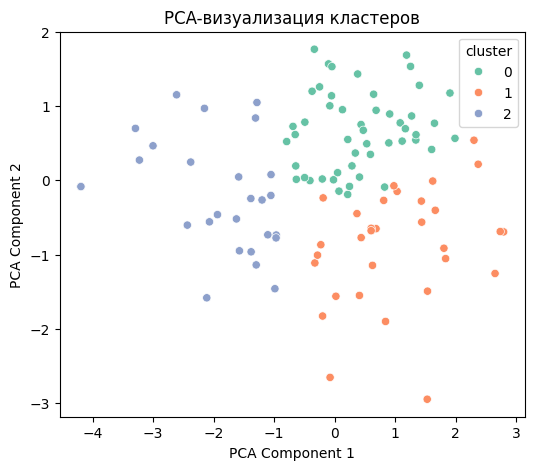

In [25]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

df_pca = df.loc[X_cluster.index].copy()
df_pca["pca_1"] = X_pca[:, 0]
df_pca["pca_2"] = X_pca[:, 1]

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df_pca,
    x="pca_1",
    y="pca_2",
    hue="cluster",
    palette="Set2"
)
plt.title("PCA-визуализация кластеров")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


### Оценка качества кластеризации (Silhouette Score)

In [26]:
sil_score = silhouette_score(X_cluster_scaled, df.loc[X_cluster.index, "cluster"])
round(sil_score,2)

0.23